In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 3.6 MB/s 
     |████████████████████████████████| 77 kB 6.0 MB/s 
     |████████████████████████████████| 895 kB 42.3 MB/s 
     |████████████████████████████████| 6.6 MB 33.3 MB/s 
     |████████████████████████████████| 596 kB 25.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import drive
import pandas as pd
import sys
drive.mount("/content/gdrive")
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/SNLP projekt')
df= pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/SNLP projekt/data/train.csv").head(100_000)
df = df.dropna()

Mounted at /content/gdrive


In [ ]:
#Group sentences together to form a pair
df['sentence_pair'] = df.apply(lambda row : [row["question1"], row["question2"]], axis = 1)

In [ ]:
#CONSTANTS
MAX_LEN = 50 # based on exploratory data analysis
BATCH_SIZE = 40 # Initial guess
MODEL_NAME = "google/electra-small-discriminator"
RANDOM_SEED = 42

In [ ]:
from transformers import ElectraTokenizer, ElectraModel, ElectraConfig
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
from Selectra import SELECTRA


if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)
#Create a proper Pytorch dataset

class Quora_questions_dataset(Dataset):
  def __init__(self, sentence_pairs, targets, tokenizer, max_len):
    self.sentence_pairs = sentence_pairs
    self.targets = targets 
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.sentence_pairs)

  def __getitem__(self, item):
    sent1, sent2 = self.sentence_pairs[item]
    target = self.targets[item]
    encoding1 = self.tokenizer(sent1, max_length = MAX_LEN, padding = "max_length", truncation = True, return_attention_mask = True)
    encoding2 = self.tokenizer(sent2, max_length = MAX_LEN, padding = "max_length", truncation = True,  return_attention_mask = True)
    return {
        "sentence_pair" : self.sentence_pairs[item],
        "input_ids": torch.tensor([encoding1["input_ids"],encoding2["input_ids"]], dtype = torch.int),
        "attention_masks": torch.tensor([encoding1["attention_mask"],encoding2["attention_mask"]], dtype = torch.int),
        "targets": torch.tensor(target, dtype=torch.long)
    }

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = Quora_questions_dataset(
    sentence_pairs=df.sentence_pair.to_numpy(),
    targets=df.is_duplicate.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

cuda


In [ ]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)


df_val, df_test = train_test_split(           
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [ ]:
tokenizer = ElectraTokenizer.from_pretrained(MODEL_NAME)
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
model = SELECTRA(n_classes = 2)
model = model.to(device)

Downloading:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def train_epoch( model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device) #shape [20,2,150]
    attention_masks = d["attention_masks"].to(device)
    targets = d["targets"].to(device)
    sentences = d["sentence_pair"]
    outputs = model(
      input_ids=input_ids,
      attention_masks = attention_masks
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_masks = d["attention_masks"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
      input_ids=input_ids,
      attention_masks = attention_masks
    )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
from transformers import  AdamW, get_linear_schedule_with_warmup
#TRAINING
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch( model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train) )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state' + str(epoch + 1) + '.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.5070074418187142 accuracy 0.7441666666666668
Val   loss 0.4489199843406677 accuracy 0.7878000000000001

Epoch 2/10
----------
Train loss 0.4279438425037596 accuracy 0.7956111111111112
Val   loss 0.4204451868534088 accuracy 0.8068000000000001

Epoch 3/10
----------
Train loss 0.3830055548283789 accuracy 0.8220333333333334
Val   loss 0.4074478622674942 accuracy 0.8092

Epoch 4/10
----------
Train loss 0.3502129825717873 accuracy 0.8419555555555556
Val   loss 0.4017337280511856 accuracy 0.8206

Epoch 5/10
----------
Train loss 0.3231490061978499 accuracy 0.8566111111111111
Val   loss 0.4033157147169113 accuracy 0.8242

Epoch 6/10
----------
Train loss 0.3013858822716607 accuracy 0.8688444444444445
Val   loss 0.4052351461648941 accuracy 0.8234

Epoch 7/10
----------
Train loss 0.28153890207740995 accuracy 0.8786555555555556
Val   loss 0.4079938006401062 accuracy 0.8242

Epoch 8/10
----------
Train loss 0.26738759432236353 accuracy 0.8862222222222222
Val  

In [ ]:
accs = [float(x.cpu()) for x in history["train_acc"]]
vals = [float(x.cpu()) for x in history["val_acc"]]

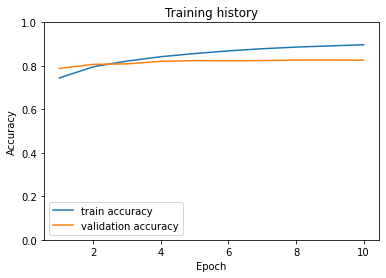

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list(range(1,EPOCHS+1)), accs, label='train accuracy')
plt.plot(list(range(1,EPOCHS+1)), vals, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.8218000000000001